In [1]:
"""Loading and caculating returns

Demonstration of how to load and calculate returns in LUSID.

Attributes
----------
Returns
"""

'Loading and caculating returns\n\nDemonstration of how to load and calculate returns in LUSID.\n\nAttributes\n----------\nReturns\n'

# Loading and calculating returns in LUSID

This notebook shows how you can load and calculate returns in LUSID. In the cells below, we load a CSV file of daily returns over a 5 year period (approximately). We then use LUSID to calculate various metics:

* Daily
* Since inception
* Month-to-date (MTD)
* Quarter-to-date (QTD)
* Year-to-date (YTD)


# Setup LUSID

In [2]:
# Import general purpose packages
import os
import json
from datetime import datetime, timedelta

# Import lusid specific packages
import lusid
import lusid.models as models
from lusid.utilities import ApiClientFactory
from lusidjam.refreshing_token import RefreshingToken

# Import data wrangling packages
import pandas as pd
import numpy as np

# Set display configuration
pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", lambda x: "%.5f" % x)
pd.set_option("display.max_rows", 500)

# Authenticate our user and create our API client
secrets_path = os.getenv("FBN_SECRETS_PATH")

# Initiate an API Factory which is the client side object for interacting with LUSID APIs
api_factory = lusid.utilities.ApiClientFactory(
    token=RefreshingToken(),
    api_secrets_filename=secrets_path,
    app_name="LusidJupyterNotebook",
)

In [3]:
# Import ploting libraries and configuration
import matplotlib.pyplot as plt

# Use line magic function to enable matplotlib to work interactively with iPython

%matplotlib inline

# Set style to fivethirtyeight to create clean and clear looking graphs

plt.style.use("fivethirtyeight")

# Define a dictionary containing default plotting configurations

params = {
    "legend.fontsize": "small",
    "figure.figsize": (12, 4.5),
    "axes.labelsize": "small",
    "axes.titlesize": "medium",
    "xtick.labelsize": "small",
    "ytick.labelsize": "small",
}

plt.rcParams.update(params)

In [4]:
# define a scope to hold data

scope = "tests"
portfolio_code = "UK_EQUITY"

In [5]:
# define the APIs we use

transaction_portfolios_api = api_factory.build(lusid.api.TransactionPortfoliosApi)
portfolios_api = api_factory.build(lusid.api.PortfoliosApi)

In [6]:
# define dates
start_date = datetime(year=2020, month=1, day=2)
number_of_days = 366

# Load a DataFrame of returns from CSV file

In [7]:
returns_df = pd.read_csv("data/performance_data.csv", dtype={'daily_returns':np.int64})
returns_df["date"] = pd.to_datetime(returns_df["date"], format="%d/%m/%Y")
returns_df = returns_df.rename(columns = {
    "mv": "market_value",
    "returns": "daily_returns"
    
})

returns_df.head()

,date,market_value,daily_returns
0,2013-12-31,1000000.00000,0.00000
1,2014-01-01,993206.38000,-0.00679
2,2014-01-02,992628.45000,-0.00058
3,2014-01-03,996394.98000,0.00379
4,2014-01-04,1002500.97000,0.00613


# Create a portfolio

In [8]:
portfolios = [portfolio_code]

for port in portfolios:

    try:

        response = transaction_portfolios_api.create_portfolio(
            scope=scope,
            create_transaction_portfolio_request=models.CreateTransactionPortfolioRequest(
                display_name=port, code=port, created="2020-01-01", base_currency="GBP"
            ),
        )
    except lusid.ApiException as e:
        print(json.loads(e.body)["title"])

Could not create a portfolio with id UK_EQUITY because it already exists in scope tests.


# Upload returns into LUSID

> <b> NOTE: We have truncated the upsert to 10 rows. Remove the cell below if you want to load all 2500+ rows of daily returns.</b>

In [9]:
# Truncate the array to 10 items
# REMOVE this cell if you want to load all rows

returns_df = returns_df[:10]

In [10]:
time_series_of_returns=[]

for index, row in returns_df.iterrows():
    
    time_series_of_returns.append(models.ModelReturn(
                effective_at=row["date"].isoformat()[:10],
                return_value=row["daily_returns"],
                market_value=row["market_value"],
                period="Daily",
            ))

In [11]:
return_code = "daily_return"

upsert_returns =  portfolios_api.upsert_portfolio_returns(
        scope=scope,
        code=portfolio_code,
        return_code=return_code,
        return_scope=scope,
        model_return=time_series_of_returns,
    )

# Retrieve returns from LUSID

In [12]:
from_effective_at = "2013-12-31"
to_effective_at = "2020-05-03"

returns = portfolios_api.get_portfolio_aggregate_returns(
    scope=scope,
    code=portfolio_code,
    return_code=return_code,
    return_scope=scope,
    from_effective_at=from_effective_at,
    to_effective_at=to_effective_at,
    period="Daily",
    output_frequency="Daily",
    metrics=["DAY", "INC", "WTD", "MTD", "QTD", "YTD"],
)

Wall time: 34.9 s


In [14]:
data = returns.values

summary_df = pd.DataFrame(
    columns=["date", "mv", "day", "inception", "wtd", "mtd", "qtd", "ytd"]
)

for item in data:

    row = {}
    row["date"] = item.effective_at
    row["mv"] = item.market_value
    row["day"] = item.metrics_value["DAY"]
    row["inception"] = item.metrics_value["INC"]
    row["mtd"] = item.metrics_value["MTD"]
    row["ytd"] = item.metrics_value["YTD"]
    row["qtd"] = item.metrics_value["QTD"]
    row["wtd"] = item.metrics_value["WTD"]

    summary_df = summary_df.append(row, ignore_index=True)

In [15]:
summary_df.tail(10)

,date,mv,day,inception,wtd,mtd,qtd,ytd
2246,2020-02-25 00:00:00+00:00,1805898.87000,-0.00250,0.80590,-0.00403,0.00248,0.08062,0.08062
2247,2020-02-26 00:00:00+00:00,1811542.30000,0.00312,0.81154,-0.00092,0.00562,0.08400,0.08400
2248,2020-02-27 00:00:00+00:00,1816147.78000,0.00254,0.81615,0.00162,0.00817,0.08675,0.08675
2249,2020-02-28 00:00:00+00:00,1826811.17000,0.00587,0.82681,0.00750,0.01409,0.09313,0.09313
2250,2020-02-29 00:00:00+00:00,1844211.21000,0.00952,0.84421,0.01710,0.02375,0.10355,0.10355
2251,2020-03-01 00:00:00+00:00,1851992.27000,0.00422,0.85199,0.02139,0.00422,0.10820,0.10820
2252,2020-03-02 00:00:00+00:00,1853193.56000,0.00065,0.85319,0.00065,0.00487,0.10892,0.10892
2253,2020-03-03 00:00:00+00:00,1852655.21000,-0.00029,0.85266,0.00036,0.00458,0.10860,0.10860
2254,2020-03-04 00:00:00+00:00,1848853.84000,-0.00205,0.84885,-0.00169,0.00252,0.10632,0.10632
2255,2020-03-05 00:00:00+00:00,1847081.89000,-0.00096,0.84708,-0.00265,0.00156,0.10526,0.10526


In [16]:
def time_series_performance():
    ts_performance = summary_df.plot(y=["ytd"], figsize=(12, 9))
    ts_performance.set_title(
        f"Performance of {portfolio_code} from {from_effective_at} to {to_effective_at}",
        fontsize="large",
    )
    ts_performance.set_ylabel("Performance in %", fontsize="large")
    ts_performance.set_xlabel("Number of days")
    ts_performance.legend(prop={"size": 12})

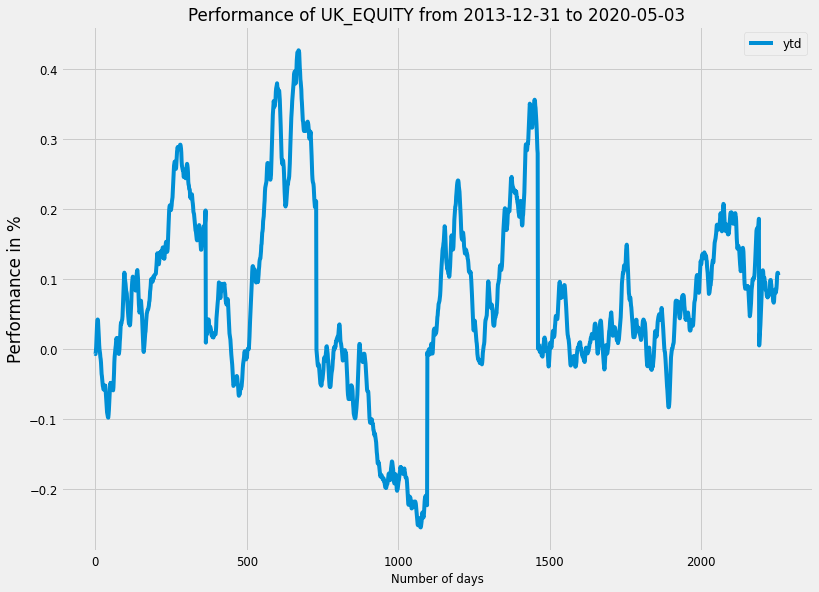

In [17]:
time_series_performance()